## Start setup



In [ ]:
import warnings
category='DeprecationWarning'
warnings.filterwarnings('ignore', category)

In [ ]:
import warnings
warnings.simplefilter("ignore", category=PendingDeprecationWarning)

In [ ]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [ ]:
# google drive settings 
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# google drive settings 
%%capture
%cd /content/gdrive/My\ Drive/NLP

In [ ]:
 %matplotlib inline
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel, LdaModel
from gensim.corpora import Dictionary
import time # to know how long training took
import multiprocessing # to speed things up by parallelizing
import numpy 
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
first_week = pd.read_csv("tweet_data/first_week_new.csv")
second_week = pd.read_csv("tweet_data/second_week_new.csv")
third_week = pd.read_csv("tweet_data/third_week_new.csv")
fourth_week = pd.read_csv("tweet_data/fourth_week_new.csv")

In [ ]:
first_week = first_week[first_week.clean_text.isna()==False] # drop all tweets without text
second_week = second_week[second_week.clean_text.isna()==False] # drop all tweets without text
third_week = third_week[third_week.clean_text.isna()==False] # drop all tweets without text
fourth_week = fourth_week[fourth_week.clean_text.isna()==False] # drop all tweets without text

 ## Find the number of topics 

In [ ]:
 def get_coherence_score(dataset, num_topics = 10):  
  limit=50000
  string_version = dataset.clean_text.apply(str)
  instances = string_version.apply(str.split)[:limit] 
  dictionary = Dictionary(instances) # create dictionary 
  dictionary.filter_extremes(no_below=50, no_above=0.3)   # get rid of words that are too rare or too frequent
  
  ldacorpus = [dictionary.doc2bow(text) for text in instances]
  tfidfmodel = TfidfModel(ldacorpus)
  model_corpus = tfidfmodel[ldacorpus] # transform raw frequencies into TFIDF

  coherence_values = []

  dev_size = 10000
  eval_size = 5000

  for num_topics in range(1, num_topics):
      model = LdaMulticore(corpus=model_corpus[:dev_size], 
                          id2word=dictionary, 
                          num_topics=num_topics)

      coherencemodel_cv = CoherenceModel(model=model, 
                                        texts=instances[dev_size:dev_size+eval_size], 
                                        dictionary=dictionary, 
                                        coherence='c_v')

      cv_score = coherencemodel_cv.get_coherence()
      
      print(num_topics, cv_score)
      coherence_values.append(cv_score)
  
  plt.figure(figsize=(12,8))
  plt.xticks(range(1,num_topics+1))
  plt.plot(range(1,num_topics+1), coherence_values, '-o')
  plt.show()

  return coherence_values

1 0.2280255678221806
2 0.28911120290855435
3 0.3060932991788774
4 0.3092345108300881
5 0.3101888807776394
6 0.3612009892020736
7 0.33388862718182183
8 0.36674340425161844
9 0.37307940141692664
10 0.3548992383511521
11 0.36886253816366726
12 0.36181021926796014
13 0.38789318035054526
14 0.3967631781218655


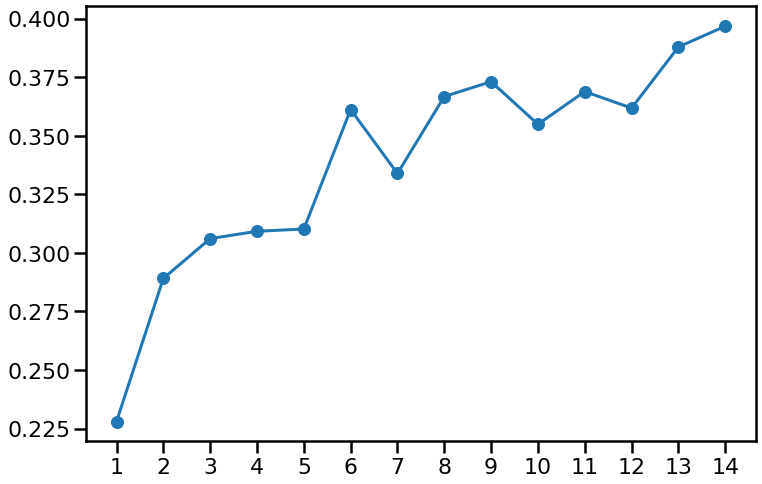

In [ ]:
w1_coherence = get_coherence_score(first_week, num_topics=15 )

1 0.37552003877830303
2 0.27845839768323943
3 0.3346135901754926
4 0.3745724028235527
5 0.40452035198766056
6 0.3685705838473956
7 0.44103900115010053
8 0.4502807253863138
9 0.4825115375493046
10 0.4760144139861368
11 0.46206820908858964
12 0.4732379999730314
13 0.4691097339632926
14 0.46467204326396533


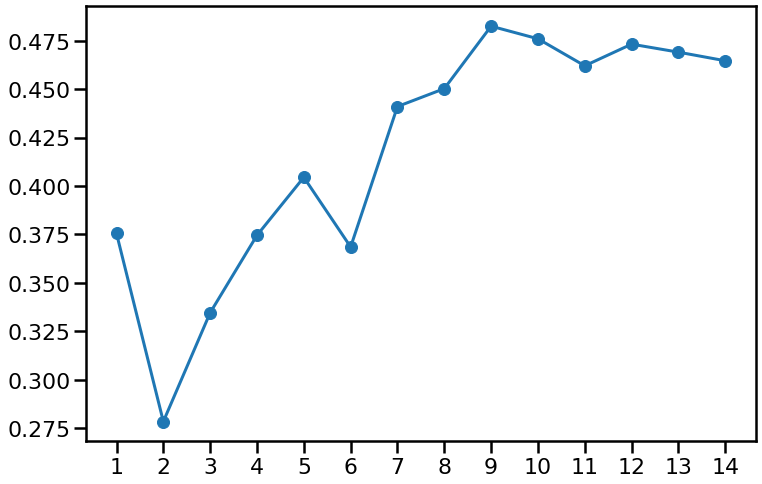

In [ ]:
w2_coherence = get_coherence_score(second_week, num_topics=15 )

1 0.3267649776881628
2 0.32897877442504087
3 0.3858268607337199
4 0.4375293326267982
5 0.42940922632440703
6 0.45772543964143875
7 0.437320929150631
8 0.49469958319148444
9 0.505174141879614
10 0.4914151657283667
11 0.5106876069226377
12 0.5430391245894356
13 0.4861363811004972
14 0.548824848518646


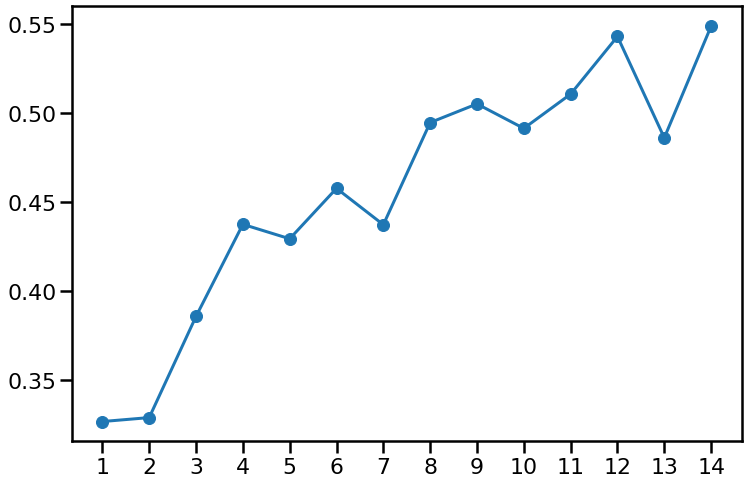

In [ ]:
w3_coherence = get_coherence_score(third_week, num_topics=15 )

1 0.3551463528627825
2 0.32543835716366154
3 0.3847598123733178
4 0.41006160829966215
5 0.4169331586302982
6 0.4390228876011018
7 0.43921390912319336
8 0.3957555516318806
9 0.483552518349036
10 0.42380668810541355
11 0.4512076734159624
12 0.4510314003568314
13 0.4470507921254008
14 0.47468575683545605


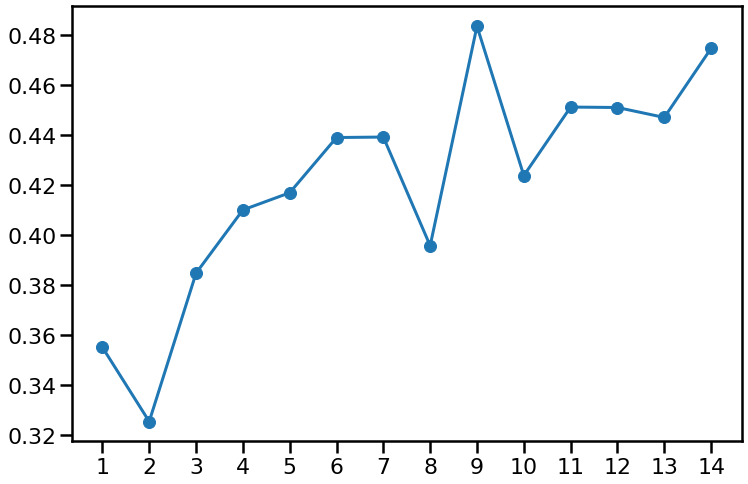

In [ ]:
w4_coherence = get_coherence_score(fourth_week, num_topics=15)

In [ ]:
k1 = 6 
k2 = 5
k3 = 4
k4 = 6

## Latent Dirichlet Allocation

In [ ]:
def lda_model(dataset, num_topics = 3): 
  
  # get dictionary
  dataset = dataset[dataset.clean_text.isna()==False] # drop all tweets without text
  documents = dataset.clean_text.apply(str) # make sure they are strings

  instances = documents.apply(str.split)
  dictionary = Dictionary(instances)
  dictionary.filter_extremes(no_below=50, no_above=0.3) # get rid of words that are too rare or too frequent

  ldacorpus = [dictionary.doc2bow(text) for text in instances]
  tfidfmodel = TfidfModel(ldacorpus) # learn TFIDF values from corpus
  model_corpus = tfidfmodel[ldacorpus] # transform raw frequencies into TFIDF

  lda_model = LdaModel(model_corpus, num_topics=num_topics, id2word=dictionary, random_state=41, alpha='auto')

  return lda_model, model_corpus, dictionary

In [ ]:
def show_topics(model): 
  for idx, topic in model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, model.show_topic(idx)))

### First week

In [ ]:
%%time
first_week_model, corpus_first_week, dictionary_first_week = lda_model(first_week, num_topics=k1)

In [ ]:
show_topics(first_week_model)

Topic: 0 
Words: [('scuola', 0.041096393), ('chiuso', 0.030847583), ('marzo', 0.023163065), ('salire', 0.021875123), ('lombardia', 0.021714045), ('regione', 0.019956663), ('emilia', 0.016531706), ('aggiornamento', 0.015534965), ('riaprire', 0.014179313), ('romagna', 0.013418307)]
Topic: 1 
Words: [('positivo', 0.014927379), ('guarire', 0.010373452), ('contagiare', 0.009715649), ('persona', 0.008482476), ('emergenza', 0.008090362), ('solere', 0.0078389635), ('ospedale', 0.007250641), ('roma', 0.0068762987), ('cinese', 0.0065526627), ('via', 0.0063754595)]
Topic: 2 
Words: [('porto', 0.03520631), ('rinviare', 0.030932192), ('giocare', 0.028665064), ('partito', 0.026468609), ('serio', 0.02407878), ('inter', 0.019887708), ('calciare', 0.01521447), ('tifoso', 0.013513847), ('gara', 0.011603921), ('campionare', 0.011590465)]
Topic: 3 
Words: [('puglia', 0.013772445), ('rosso', 0.013621343), ('paziente', 0.0123841185), ('zaia', 0.012117675), ('sanità', 0.0108592035), ('miliardo', 0.009123119)

In [ ]:
%%time
first_week_model_3, corpus_first_week_3, dictionary_first_week_3 = lda_model(first_week, num_topics=3)

CPU times: user 42 s, sys: 299 ms, total: 42.3 s
Wall time: 42.4 s


In [ ]:
show_topics(first_week_model_3)

Topic: 0 
Words: [('contagiare', 0.010517118), ('morto', 0.009710797), ('marzo', 0.0076981992), ('salire', 0.007269497), ('contagio', 0.006358183), ('emergenza', 0.0058616363), ('mondare', 0.0056241537), ('settimana', 0.005515979), ('aggiornamento', 0.0050900183), ('decretare', 0.005056038)]
Topic: 1 
Words: [('positivo', 0.014627019), ('scuola', 0.009968166), ('chiuso', 0.007983279), ('guarire', 0.0073051457), ('quarantena', 0.006739397), ('persona', 0.0060931053), ('ospedale', 0.005819809), ('regione', 0.0056283833), ('emilia', 0.0052542486), ('roma', 0.005244229)]
Topic: 2 
Words: [('rinviare', 0.0112369545), ('porto', 0.010799685), ('giocare', 0.0101694595), ('volo', 0.00952206), ('partito', 0.009406827), ('serio', 0.008799872), ('repubblica', 0.008029177), ('inter', 0.007080716), ('dato', 0.0069582136), ('cina', 0.006845748)]


### Second week

In [ ]:
%%time
second_week_model, corpus_second_week, dictionary_second_week = lda_model(second_week, num_topics=k2)

CPU times: user 1min 7s, sys: 358 ms, total: 1min 7s
Wall time: 1min 7s


In [ ]:
show_topics(second_week_model)

Topic: 0 
Words: [('medico', 0.013434168), ('attività', 0.0108448295), ('chiudere', 0.010499965), ('emergenza', 0.009317545), ('ospedale', 0.0088567315), ('mondare', 0.0075878743), ('aiutare', 0.007572974), ('repubblica', 0.0075192377), ('essenziale', 0.0073206057), ('notizia', 0.006536959)]
Topic: 1 
Words: [('provincia', 0.010150764), ('medicare', 0.009421987), ('farmaco', 0.009308723), ('avigan', 0.009148655), ('cina', 0.009129025), ('terapia', 0.008451861), ('cubano', 0.008433534), ('intensivo', 0.008127738), ('cubare', 0.007932598), ('merkel', 0.0077222935)]
Topic: 2 
Words: [('conta', 0.012954014), ('morire', 0.012672717), ('decretare', 0.011019466), ('governare', 0.009699136), ('stop', 0.00894006), ('misura', 0.0077974163), ('milano', 0.0070272065), ('calere', 0.0068611284), ('firmare', 0.0064886585), ('famiglia', 0.006300956)]
Topic: 3 
Words: [('quarantena', 0.021686085), ('casa', 0.013991998), ('solere', 0.008859701), ('andare', 0.007791933), ('persona', 0.0076286644), ('sape

### Third week

In [ ]:
%%time
third_week_model, corpus_third_week, dictionary_third_week = lda_model(third_week, num_topics=k3)

CPU times: user 37.6 s, sys: 141 ms, total: 37.7 s
Wall time: 37.8 s


In [ ]:
show_topics(third_week_model)

Topic: 0 
Words: [('notizia', 0.013011782), ('mondare', 0.011815759), ('aggiornamento', 0.011419692), ('sindacare', 0.009104004), ('repubblica', 0.008408469), ('dirigere', 0.008293711), ('sicilia', 0.008292074), ('numero', 0.0077529377), ('sì', 0.007568366), ('napoli', 0.0069253272)]
Topic: 1 
Words: [('conta', 0.017289694), ('governare', 0.008401328), ('emergenza', 0.008165793), ('stampare', 0.005781097), ('famiglia', 0.0056524947), ('chiedere', 0.0056413086), ('settembre', 0.0056399014), ('conferenza', 0.0055982065), ('scuola', 0.005578689), ('amp', 0.0055379043)]
Topic: 2 
Words: [('quarantena', 0.024562309), ('casa', 0.0100271525), ('fase', 0.009038234), ('andare', 0.008995764), ('maggio', 0.008628793), ('vedere', 0.007242941), ('uscire', 0.0069738226), ('mascherina', 0.006582277), ('sapere', 0.0060756644), ('solere', 0.0057594823)]
Topic: 3 
Words: [('positivo', 0.019696483), ('morto', 0.018390922), ('aprile', 0.016130693), ('decesso', 0.015607347), ('contagio', 0.015028126), ('gu

### Fourth week

In [ ]:
%%time
fourth_week_model, corpus_fourth_week, dictionary_fourth_week = lda_model(fourth_week, num_topics=k4)

CPU times: user 19.5 s, sys: 43.6 ms, total: 19.6 s
Wall time: 19.6 s


In [ ]:
show_topics(fourth_week_model)

Topic: 0 
Words: [('quarantena', 0.01556683), ('andare', 0.007198575), ('casa', 0.006777221), ('mese', 0.006688193), ('solere', 0.0057863365), ('movida', 0.005632726), ('uscire', 0.005497977), ('sapere', 0.0054847877), ('emergenza', 0.0053680716), ('pensare', 0.0052599707)]
Topic: 1 
Words: [('distruggere', 0.0138979675), ('uso', 0.008832474), ('morire', 0.008489378), ('civile', 0.0077372794), ('protezione', 0.007550472), ('mondare', 0.0068382584), ('comune', 0.0063437647), ('milione', 0.006225653), ('veneto', 0.0061021545), ('spiegare', 0.0060750823)]
Topic: 2 
Words: [('video', 0.010266762), ('spuntare', 0.010019549), ('anti', 0.009446248), ('calabria', 0.0072442507), ('vaccinare', 0.007179699), ('palestra', 0.0068964506), ('liguria', 0.0065949815), ('piscina', 0.006298004), ('capitare', 0.006220911), ('sardegna', 0.005708858)]
Topic: 3 
Words: [('morto', 0.034607112), ('positivo', 0.032395497), ('lombardia', 0.030939225), ('decesso', 0.029624872), ('contagio', 0.025628831), ('dato',

### Visualization with pyLDAvis

In [ ]:
%%capture 
! pip install pyLDAvis

In [ ]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
panel = pyLDAvis.gensim.prepare(first_week_model, corpus_first_week, dictionary_first_week, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
1       1.465019 -47.625065       1        1  30.132133
4      54.854797 -36.476795       2        1  25.349930
5      32.212929 -61.444572       3        1  14.471781
0       5.111096 -14.110332       4        1  12.048573
3      26.350170 -33.374702       5        1  10.886415
2      38.109818  -7.222781       6        1   7.111169, topic_info=           Term         Freq        Total Category  logprob  loglift
168      scuola  2476.000000  2476.000000  Default  30.0000  30.0000
164      chiuso  2171.000000  2171.000000  Default  29.0000  29.0000
141       morto  2053.000000  2053.000000  Default  28.0000  28.0000
484       porto  1351.000000  1351.000000  Default  27.0000  27.0000
1374      marzo  1383.000000  1383.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
804      tifoso   476.243286   504.066467   Topic6  -4.3040   2.5867
368       sport   245.119446   255.608734   Topic6  -4.9682   2.6016
2239    effetto   333.696930   502.858643   Topic6  -4.6597   2.2334
173   decretare   376.261719  1101.618408   Topic6  -4.5397   1.5693
164      chiuso   312.696442  2171.441650   Topic6  -4.7247   0.7056

[351 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
541       4  0.998430      accertare
823       3  0.041176     affrontare
823       5  0.958805     affrontare
77        2  0.001071  aggiornamento
77        4  0.993968  aggiornamento
...     ...       ...            ...
299       1  0.381867           zona
299       2  0.179642           zona
299       3  0.034902           zona
299       4  0.007186           zona
299       5  0.395212           zona

[649 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 6, 1, 4, 3])

In [ ]:
# pyLDAvis.save_html(panel, 'tweet_data/lda_first_week.html')

## K-Means

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

stop_word_file = open("tweet_data/italian_stop_words.txt", "r")
stopwords_italian = stop_word_file.read().split('\n')

def k_means_pp(dataset, k = 3, stopwords = stopwords_italian): 
  vectorizer = TfidfVectorizer(stop_words=stopwords_italian)
  dataset = dataset[dataset['clean_text'].notnull()] 
  X = vectorizer.fit_transform(dataset['clean_text'])

  model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1, random_state = 1)
  model.fit(X)

  return model, vectorizer

In [ ]:
def print_topic(model,vectorizer, k = 3, num_words = 10 ): 
  print("Top terms per cluster:")
  order_centroids = model.cluster_centers_.argsort()[:, ::-1]
  terms = vectorizer.get_feature_names()
  for i in range(k):
      print("Cluster %d:" % i),
      for ind in order_centroids[i, :num_words]:
          print(' %s' % terms[ind]),

### First week

In [ ]:
%time w1_model, w1_vect = k_means_pp(first_week, k1)

CPU times: user 1min 15s, sys: 4.01 s, total: 1min 19s
Wall time: 1min 14s


In [ ]:
print_topic(w1_model, w1_vect, k1)

Top terms per cluster:
Cluster 0:
 quarantena
 andare
 casa
 migrare
 persona
 arrivare
 cina
 italiano
 sbarcare
 codogno
Cluster 1:
 scuola
 chiuso
 porto
 lombardia
 regione
 università
 marzo
 chiudere
 chiusura
 museo
Cluster 2:
 positivo
 test
 donna
 risultare
 tampone
 salire
 turista
 paziente
 persona
 palermo
Cluster 3:
 rischiare
 situazione
 prendere
 lavorare
 solere
 andare
 uscire
 italiano
 emergenza
 persona
Cluster 4:
 emergenza
 italiano
 solere
 sapere
 governare
 mascherina
 milano
 regione
 casa
 andare
Cluster 5:
 contagiare
 morto
 vittima
 salire
 contagio
 lombardia
 guarire
 numerare
 matematico
 ragionare


In [ ]:
%time w1_model_3, w1_vect_3 = k_means_pp(first_week, 3)

CPU times: user 38.6 s, sys: 2.02 s, total: 40.6 s
Wall time: 38.2 s


In [ ]:
print_topic(w1_model_3, w1_vect_3, 3)

Top terms per cluster:
Cluster 0:
 contagiare
 quarantena
 italiano
 emergenza
 solere
 morto
 sapere
 persona
 andare
 governare
Cluster 1:
 scuola
 chiuso
 porto
 lombardia
 università
 regione
 chiudere
 marzo
 chiusura
 museo
Cluster 2:
 positivo
 test
 donna
 risultare
 tampone
 salire
 turista
 paziente
 persona
 palermo


### Second week

In [ ]:
%time w2_model, w2_vect = k_means_pp(second_week, k2)

CPU times: user 1min 23s, sys: 2.75 s, total: 1min 26s
Wall time: 1min 23s


In [ ]:
print_topic(w2_model, w2_vect, k2)

Top terms per cluster:
Cluster 0:
 quarantena
 positivo
 morto
 contagiare
 marzo
 solere
 andare
 guarire
 persona
 sapere
Cluster 1:
 emergenza
 sanitario
 misura
 ospedale
 affrontare
 governare
 decretare
 italiano
 medico
 fronteggiare
Cluster 2:
 lombardia
 milano
 morto
 regione
 fontana
 gallera
 contagio
 ospedale
 positivo
 contagiare
Cluster 3:
 neo
 supermercato
 parco
 confronto
 prossimo
 casa
 lavorare
 pennarello
 solere
 biancheria
Cluster 4:
 casa
 restare
 quarantena
 uscire
 andare
 solere
 rimanere
 lavorare
 chiuso
 persona


In [ ]:
%time w2_model_4, w2_vect_4 = k_means_pp(second_week, 4)

CPU times: user 1min 41s, sys: 3.35 s, total: 1min 44s
Wall time: 1min 40s


In [ ]:
print_topic(w2_model_4, w2_vect_4, 4)

Top terms per cluster:
Cluster 0:
 quarantena
 casa
 positivo
 morto
 contagiare
 marzo
 solere
 guarire
 persona
 sapere
Cluster 1:
 emergenza
 andare
 casa
 quarantena
 lavorare
 sanitario
 uscire
 solere
 ospedale
 misura
Cluster 2:
 lombardia
 milano
 morto
 regione
 fontana
 gallera
 ospedale
 contagio
 positivo
 contagiare
Cluster 3:
 neo
 bambino
 casa
 supermercato
 parco
 solere
 quarantena
 lavorare
 confronto
 prossimo


### Third week

In [ ]:
%time w3_model, w3_vect = k_means_pp(third_week, k3)

CPU times: user 1min 18s, sys: 4.35 s, total: 1min 23s
Wall time: 1min 17s


In [ ]:
print_topic(w3_model, w3_vect, k3)

Top terms per cluster:
Cluster 0:
 quarantena
 casa
 emergenza
 solere
 andare
 sapere
 italiano
 lavorare
 via
 mascherina
Cluster 1:
 fase
 aprile
 maggio
 regione
 dato
 conta
 contagio
 riaprire
 riapertura
 bollettino
Cluster 2:
 positivo
 morto
 decesso
 guarire
 contagio
 calere
 bollettino
 salire
 totale
 ancorare
Cluster 3:
 appositamente
 minlavoro
 studiato
 elenabonetti
 azzolinalucia
 fallare
 forma
 grosso
 superare
 giuseppeconteit


In [ ]:
%time w3_model_3, w3_vect_3 = k_means_pp(third_week, 3)

CPU times: user 1min 1s, sys: 3.44 s, total: 1min 4s
Wall time: 1min


In [ ]:
print_topic( w3_model_3, w3_vect_3, 3)

Top terms per cluster:
Cluster 0:
 quarantena
 casa
 emergenza
 solere
 andare
 sapere
 italiano
 lavorare
 via
 mascherina
Cluster 1:
 fase
 aprile
 maggio
 regione
 dato
 conta
 contagio
 riaprire
 riapertura
 bollettino
Cluster 2:
 positivo
 morto
 decesso
 guarire
 contagio
 calere
 bollettino
 salire
 totale
 ancorare


In [ ]:
%time w3_model_3, w3_vect_3 = k_means_pp(third_week, 6)

CPU times: user 26.1 s, sys: 1.33 s, total: 27.4 s
Wall time: 25.9 s


In [ ]:
print_topic(w3_model_3, w3_vect_3, 6)

Top terms per cluster:
Cluster 0:
 emergenza
 sanitario
 giuseppeconteit
 superare
 minlavoro
 appositamente
 elenabonetti
 forma
 studiato
 azzolinalucia
Cluster 1:
 casa
 quarantena
 riposare
 uscire
 restare
 tornire
 andare
 chiuso
 anziano
 solere
Cluster 2:
 quarantena
 andare
 vedere
 finire
 uscire
 sapere
 solere
 pensare
 iniziare
 persona
Cluster 3:
 leggere
 articolare
 quarantena
 emergenza
 notizia
 casa
 andare
 ospedale
 gt
 sapere
Cluster 4:
 fase
 solere
 mascherina
 maggio
 regione
 via
 conta
 aprile
 contagiare
 mondare
Cluster 5:
 positivo
 morto
 guarire
 decesso
 contagio
 calere
 aprile
 dato
 bollettino
 salire


In [ ]:
%time w3_model_12, w3_vect_12 = k_means_pp(third_week, 12)

CPU times: user 1min 8s, sys: 3.56 s, total: 1min 12s
Wall time: 1min 7s


In [ ]:
print_topic(w3_model_12, w3_vect_12, 12)

Top terms per cluster:
Cluster 0:
 emergenza
 sanitario
 giuseppeconteit
 minlavoro
 appositamente
 elenabonetti
 forma
 studiato
 azzolinalucia
 fallare
Cluster 1:
 positivo
 guarire
 calere
 tampone
 sicilia
 contagio
 ricovero
 aumentare
 ancorare
 intensivo
Cluster 2:
 repubblica
 via
 morto
 contagio
 rep
 milano
 oms
 dare
 lombardia
 mondare
Cluster 3:
 fase
 conta
 auto
 changeitalia
 petizione
 firmare
 giuseppe
 maggio
 scontare
 prorogare
Cluster 4:
 iniziare
 quarantena
 fase
 emergenza
 epidemia
 settimana
 maggio
 solere
 vedere
 pandemia
Cluster 5:
 solere
 mascherina
 contagiare
 mondare
 italiano
 via
 lavorare
 sapere
 andare
 parlare
Cluster 6:
 regione
 lombardia
 dato
 contagio
 fase
 maggio
 spostamento
 milione
 zero
 campania
Cluster 7:
 quarantena
 andare
 vedere
 uscire
 sapere
 finire
 solere
 pensare
 persona
 passare
Cluster 8:
 morto
 contagio
 calere
 guarire
 positivo
 salire
 lombardia
 mondare
 contagiare
 ancorare
Cluster 9:
 decesso
 contagio
 guarir

### Fourth week

In [ ]:
%time w4_model, w4_vect = k_means_pp(fourth_week, k4)

CPU times: user 27.8 s, sys: 2.85 s, total: 30.6 s
Wall time: 27.3 s


In [ ]:
print_topic(w4_model, w4_vect, k4)

Top terms per cluster:
Cluster 0:
 morto
 contagio
 decesso
 guarire
 lombardia
 salire
 bollettino
 totale
 calere
 maggio
Cluster 1:
 dato
 maggio
 regione
 bollettino
 protezione
 civile
 aggiornato
 lombardia
 provincia
 odierno
Cluster 2:
 quarantena
 uscire
 casa
 mese
 andare
 italiano
 twitter
 finito
 profilo
 iniziare
Cluster 3:
 positivo
 guarire
 decesso
 tampone
 bollettino
 morto
 maggio
 scendere
 test
 calere
Cluster 4:
 fase
 riaprire
 riapertura
 emergenza
 maggio
 rischiare
 regione
 contagio
 conta
 mascherina
Cluster 5:
 emergenza
 contagiare
 mascherina
 solere
 lavorare
 regione
 mondare
 rischiare
 vaccinare
 sapere


In [ ]:
%time w4_model_9, w4_vect_9 = k_means_pp(fourth_week, 9)

CPU times: user 20.2 s, sys: 2 s, total: 22.2 s
Wall time: 19.9 s


In [ ]:
print_topic( w4_model_9, w4_vect_9, 9)

Top terms per cluster:
Cluster 0:
 decesso
 positivo
 guarire
 contagio
 tampone
 calere
 zero
 lombardia
 scendere
 provincia
Cluster 1:
 dato
 maggio
 regione
 bollettino
 positivo
 lombardia
 provincia
 aggiornato
 odierno
 contagio
Cluster 2:
 morto
 bollettino
 contagio
 salire
 maggio
 lombardia
 positivo
 totale
 guarire
 decesso
Cluster 3:
 emergenza
 news
 fake
 profilo
 italiano
 diffusore
 twitter
 super
 sanitario
 repubblica
Cluster 4:
 mascherina
 contagio
 contagiare
 fase
 solere
 mondare
 lavorare
 rischiare
 vaccinare
 regione
Cluster 5:
 persona
 via
 andare
 libero
 positivo
 mascherina
 solere
 contagiare
 test
 lavorare
Cluster 6:
 quarantena
 uscire
 casa
 mese
 finito
 iniziare
 amico
 andare
 vedere
 solere
Cluster 7:
 mercato
 analisi
 crescita
 previsione
 impattare
 tendenza
 fattore
 attore
 settore
 immobiliare
Cluster 8:
 protezione
 civile
 dato
 bollettino
 morto
 guarire
 maggio
 contagio
 inps
 dpcgov
